In [12]:
import numpy as np
import pandas as pd
import os
import PIL
from PIL import Image
import torch
import torch.nn as nn
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from sklearn import model_selection, metrics
from torch.utils.data import random_split

import torchvision.datasets as datasets
from torchvision.transforms import ToTensor
import torch.nn as nn

In [13]:
np.random.seed(0)
torch.manual_seed(0)

In [14]:
transform = ToTensor()
train_set = datasets.CIFAR10(root='./../datasets', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./../datasets', train=False, download=True, transform=transform)

Files already downloaded and verified
Files already downloaded and verified


In [15]:
classes = train_set.classes
classes

['airplane',
 'automobile',
 'bird',
 'cat',
 'deer',
 'dog',
 'frog',
 'horse',
 'ship',
 'truck']

In [16]:
class_count = {}
for _, index in train_set:
    label = classes[index]
    if label not in class_count:
        class_count[label] = 0
    class_count[label] += 1
class_count

{'frog': 5000,
 'truck': 5000,
 'deer': 5000,
 'automobile': 5000,
 'bird': 5000,
 'horse': 5000,
 'ship': 5000,
 'cat': 5000,
 'dog': 5000,
 'airplane': 5000}

In [17]:
val_size = 5000
train_size = len(train_set) - val_size

In [21]:
train_ds, val_ds = random_split(train_set, [train_size, val_size])
len(train_ds), len(val_ds)

(45000, 5000)

In [27]:
batch_size=128
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import CIFAR10
from torchvision.transforms import ToTensor
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
%matplotlib inline

In [29]:
train_loader = DataLoader(train_set, batch_size, shuffle=True, num_workers=4, pin_memory=True)
#val_loader = DataLoader(val_ds, batch_size*2, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_set, batch_size*2, num_workers=4, pin_memory=True)

images.shape: torch.Size([128, 3, 32, 32])


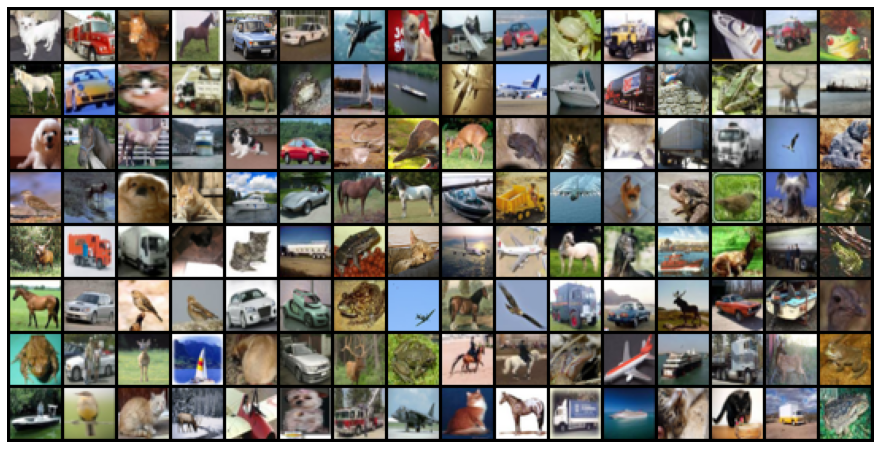

In [30]:
for images, _ in train_loader:
    print('images.shape:', images.shape)
    plt.figure(figsize=(16,8))
    plt.axis('off')
    plt.imshow(make_grid(images, nrow=16).permute((1, 2, 0)))
    break

In [31]:
class ViT(nn.Module):
    def __init__(self, input_shape, n_patches=4, hidden=8, num_heads=2, n_classes=10):
        # Super constructor
        super(ViT, self).__init__()

        # Input and patches sizes
        self.input_shape = input_shape
        self.n_patches = n_patches
        self.num_heads = num_heads
        assert input_shape[1] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        assert input_shape[2] % n_patches == 0, "Input shape not entirely divisible by number of patches"
        self.patch_size = (input_shape[1] / n_patches, input_shape[2] / n_patches)
        self.hidden = hidden

        # 1) Linear mapper
        self.input = int(input_shape[0] * self.patch_size[0] * self.patch_size[1])
        self.linear_mapper = nn.Linear(self.input, self.hidden)

        # 2) Classification token
        self.class_token = nn.Parameter(torch.rand(1, self.hidden))

        # 3) Positional embedding
        # (In forward method)

        # 4a) Layer normalization 1
        self.ln1 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden))

        # 4b) Multi-head Self Attention (MSA) and classification token
        self.attn = Attention(self.hidden, num_heads)

        # 5a) Layer normalization 2
        self.ln2 = nn.LayerNorm((self.n_patches ** 2 + 1, self.hidden))

        # 5b) Encoder MLP
        self.mlpenc = nn.Sequential(
            nn.Linear(self.hidden, self.hidden),
            nn.ReLU()
        )

        # 6) Classification MLP
        self.mlp = nn.Sequential(
            nn.Linear(self.hidden, n_classes),
            nn.Softmax(dim=-1)
        )

    def forward(self, images):
        # Dividing images into patches
        n, c, w, h = images.shape
        patches = images.reshape(n, self.n_patches ** 2, self.input)

        # Running linear layer for tokenization
        tokens = self.linear_mapper(patches)

        # Adding classification token to the tokens
        tokens = torch.stack([torch.vstack((self.class_token, tokens[i])) for i in range(len(tokens))])

        # Adding positional embedding
        tokens += get_positional_embeddings(self.n_patches ** 2 + 1, self.hidden).repeat(n, 1, 1)

        # TRANSFORMER ENCODER BEGINS ###################################
        # NOTICE: MULTIPLE ENCODER BLOCKS CAN BE STACKED TOGETHER ######
        # Running Layer Normalization, MSA and residual connection
        output = tokens + self.attn(self.ln1(tokens))

        # Running Layer Normalization, MLP and residual connection
        output = output + self.mlpenc(self.ln2(output))
        # TRANSFORMER ENCODER ENDS   ###################################

        # Getting the classification token only
        output = output[:, 0]

        return self.mlp(output)

In [32]:
class Attention(nn.Module):
    def __init__(self, d, num_heads=2):
        super(Attention, self).__init__()
        self.d = d
        self.num_heads = num_heads

        #assert d % n_heads == 0, f"Can't divide dimension {d} into {n_heads} heads"

        d_head = int(d / num_heads)
        self.q_mappings = [nn.Linear(d_head, d_head) for _ in range(self.num_heads)]
        self.k_mappings = [nn.Linear(d_head, d_head) for _ in range(self.num_heads)]
        self.v_mappings = [nn.Linear(d_head, d_head) for _ in range(self.num_heads)]
        self.d_head = d_head
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, sequences):
        # Sequences has shape (N, seq_length, token_dim)
        # We go into shape    (N, seq_length, n_heads, token_dim / n_heads)
        # And come back to    (N, seq_length, item_dim)  (through concatenation)
        result = []
        for sequence in sequences:
            seq_result = []
            for head in range(self.num_heads):
                q_mapping = self.q_mappings[head]
                k_mapping = self.k_mappings[head]
                v_mapping = self.v_mappings[head]

                seq = sequence[:, head * self.d_head: (head + 1) * self.d_head]
                q, k, v = q_mapping(seq), k_mapping(seq), v_mapping(seq)

                attention = self.softmax(q @ k.T / (self.d_head ** 0.5))
                seq_result.append(attention @ v)
            result.append(torch.hstack(seq_result))
        return torch.cat([torch.unsqueeze(r, dim=0) for r in result])

In [33]:
def get_positional_embeddings(sequence_length, d):
    result = torch.ones(sequence_length, d)
    for i in range(sequence_length):
        for j in range(d):
            result[i][j] = np.sin(i / (10000 ** (j / d))) if j % 2 == 0 else np.cos(i / (10000 ** ((j - 1) / d)))
    return result

In [36]:
def main():
    # Defining model and training options
    model = ViT((3, 32, 32), n_patches=4, hidden=20, num_heads=2, n_classes=10)
    N_EPOCHS = 40
    LR = 0.01

    # Training loop
    optimizer = Adam(model.parameters(), lr=LR)
    criterion = CrossEntropyLoss()
    for epoch in range(N_EPOCHS):
        train_loss = 0.0
        for batch in train_loader:
            x, y = batch
            y_hat = model(x)
            loss = criterion(y_hat, y) / len(x)

            train_loss += loss.item()

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        print(f"Epoch {epoch + 1}/{N_EPOCHS} loss: {train_loss:.2f}")

    # Test loop
    correct, total = 0, 0
    test_loss = 0.0
    for batch in test_loader:
        x, y = batch
        y_hat = model(x)
        loss = criterion(y_hat, y) / len(x)
        test_loss += loss

        correct += torch.sum(torch.argmax(y_hat, dim=1) == y).item()
        total += len(x)
    print(f"Test loss: {test_loss:.2f}")
    print(f"Test accuracy: {correct / total * 100:.2f}%")


In [37]:
if __name__ == '__main__':
    main()

Epoch 1/40 loss: 6.80
Epoch 2/40 loss: 6.55
Epoch 3/40 loss: 6.46
Epoch 4/40 loss: 6.43
Epoch 5/40 loss: 6.39
Epoch 6/40 loss: 6.37
Epoch 7/40 loss: 6.35
Epoch 8/40 loss: 6.35
Epoch 9/40 loss: 6.32
Epoch 10/40 loss: 6.32
Epoch 11/40 loss: 6.31
Epoch 12/40 loss: 6.30
Epoch 13/40 loss: 6.29
Epoch 14/40 loss: 6.28
Epoch 15/40 loss: 6.28
Epoch 16/40 loss: 6.26
Epoch 17/40 loss: 6.25
Epoch 18/40 loss: 6.25
Epoch 19/40 loss: 6.23
Epoch 20/40 loss: 6.23
Epoch 21/40 loss: 6.23
Epoch 22/40 loss: 6.23
Epoch 23/40 loss: 6.22
Epoch 24/40 loss: 6.22
Epoch 25/40 loss: 6.22
Epoch 26/40 loss: 6.21
Epoch 27/40 loss: 6.21
Epoch 28/40 loss: 6.20
Epoch 29/40 loss: 6.20
Epoch 30/40 loss: 6.20
Epoch 31/40 loss: 6.19
Epoch 32/40 loss: 6.19
Epoch 33/40 loss: 6.18
Epoch 34/40 loss: 6.19
Epoch 35/40 loss: 6.19
Epoch 36/40 loss: 6.18
Epoch 37/40 loss: 6.18
Epoch 38/40 loss: 6.18
Epoch 39/40 loss: 6.17
Epoch 40/40 loss: 6.17
Test loss: 0.44
Test accuracy: 43.26%
